### Implementation of your own block matching algorithm for stereo depth reconstruction. 


You are not allowed to use cv2.matchTemplate, cv2.stereoBM or similar functions from opencv or other pre-existing libraries

1. Implement a function that takes two equal size images and calculates the sum of absolute differences. The two equal-sized images are nose_left.png (used as the template) and nose_right.png.

2. Using the function you just created, find which of the three images nose1.png, nose2.png, nose3.png gives the best match to nose_left.png?

3. Since these images are rectified, we can approximately assume that a pixel found in row x in the left image also lives in row x in the right image. nose_span.png contains the entire row containing the nose of the sculpture. The height of the span is 7 - the same height as your template. Write a function that loops through the image from left to right and computes the correlation using your function from step 1 to find where in the span the nose is located.


In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
plt.gray()

<Figure size 432x288 with 0 Axes>

## Initial images

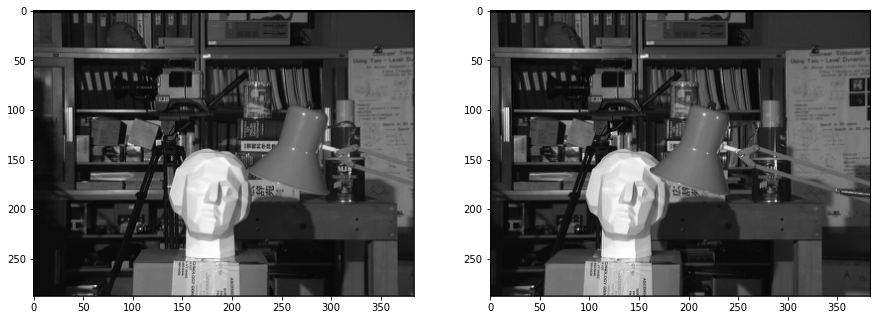

In [2]:
img_left = cv2.imread("tsukuba_left.png")
img_right = cv2.imread("tsukuba_right.png")

img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
gray_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)

img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
gray_right= cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(gray_left)
axarr[1].imshow(gray_right)

## Noses

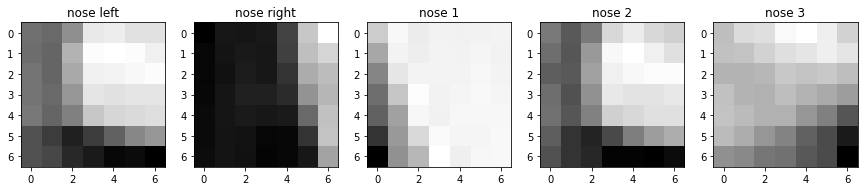

In [3]:
nose_left = cv2.imread("nose_left.png")
nose_right = cv2.imread("nose_right.png")
noses = [cv2.imread("nose1.png"), cv2.imread("nose2.png"), cv2.imread("nose3.png")]

nose_left = cv2.cvtColor(nose_left, cv2.COLOR_BGR2RGB)
nose_gray_left = cv2.cvtColor(nose_left, cv2.COLOR_RGB2GRAY)

nose_right = cv2.cvtColor(nose_right, cv2.COLOR_BGR2RGB)
nose_gray_right= cv2.cvtColor(nose_right, cv2.COLOR_RGB2GRAY)

noses_gray = []
for i, nose in enumerate(noses):
    nose = cv2.cvtColor(nose, cv2.COLOR_BGR2RGB)
    noses_gray.append(cv2.cvtColor(nose, cv2.COLOR_RGB2GRAY))
    
f, axarr = plt.subplots(1,5, figsize = (15,15))
axarr[0].imshow(nose_gray_left)
axarr[0].set_title("nose left")
axarr[1].imshow(nose_gray_right)
axarr[1].set_title("nose right")
for i, nose in enumerate(noses_gray):
    axarr[2+i].imshow(nose)
    axarr[2+i].set_title(f"nose {i+1}")
    

## Absolute differences

In [41]:
def absoluteDifference(img1, img2):
    return np.sum(cv2.absdiff(img1,img2))

print(absoluteDifference(nose_left, nose_right))

22971


## Best match for nose left

In [42]:
diff = [absoluteDifference(nose_gray_left, cv2.cvtColor(nose, cv2.COLOR_RGB2GRAY)) for nose in noses]
print(f"Best matching image: nose {np.argmin(diff)+1}")

Best matching image: nose 2


## Span best correlation

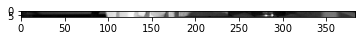

In [154]:
nose_span = cv2.imread("nose_span.png")

nose_span = cv2.cvtColor(nose_span, cv2.COLOR_BGR2RGB)
nose_span_grey = cv2.cvtColor(nose_span, cv2.COLOR_RGB2GRAY)

plt.imshow(nose_span_grey)
plt.figsize = (15,15)

kernel size is (7, 7)
span size is (384, 7)
119
[[201 193 201 225 230 225 223]
 [198 192 209 233 235 231 227]
 [194 193 211 231 233 234 234]
 [198 191 207 229 228 228 229]
 [199 192 203 223 225 227 227]
 [194 183 179 189 202 210 214]
 [191 183 180 171 171 170 173]]
132


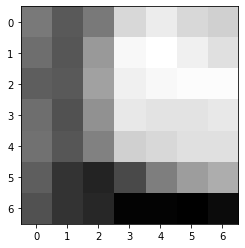

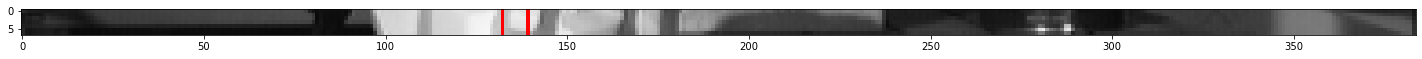

In [59]:
kernel_size =  len(nose_gray_left[0]), len(nose_gray_left)
span_size = len(nose_span_grey[0]), len(nose_span_grey),
print(f"kernel size is {kernel_size}")
print(f"span size is {span_size}")



best_score = -1
for idx in range(span_size[0] - 6):    
    kernel = nose_span_grey[:,idx:idx+7]
    score = absoluteDifference(nose_gray_left, kernel)
    if score < best_score or best_score == -1:
        best_score = score
        best_kernel = kernel
        best_kernel_idx = idx

print(best_score)
print(best_kernel)
print(best_kernel_idx)
plt.imshow(best_kernel)

plt.figure(figsize=(25,30))
output_img = nose_span.copy()
output_img1 = cv2.rectangle(output_img, (best_kernel_idx,-1),(best_kernel_idx+7, 8),(255, 0, 0),1)
plt.imshow(output_img1)


In [143]:
def findscore(span, kernel):
    best_score = float(np.inf)
    for idx in range(span.shape[1] - 6): 
        score = absoluteDifference(span[:,idx:idx+7], kernel)
        if score < best_score:
            best_score = score
            best_kernel = kernel
            best_kernel_idx = idx
    return [best_score, best_kernel_idx]

In [157]:
def absoluteDifference(img1, img2):
    diff = cv2.absdiff(img1, img2)
    return diff

def correlation(img1, img2):
    return np.sum(absoluteDifference(img1, img2))

def findBestInRow(match, span):
    kernel_size =  len(match[0]), len(match)
    span_size = len(span[0]), len(span),
#     print(f"kernel size is {kernel_size}")
#     print(f"span size is {span_size}")
    best_score = float("inf")
    best_start = -1
    for start in range(span_size[0] - kernel_size[0] + 1):
        kernel = span[:, start:start+7]
        score = correlation(match, kernel)
        if  score < best_score:
            best_score = score
            best_start = start
            
    return best_start, best_score  

In [176]:
score_mat = [[None]*(gray_left.shape[0]-6)]*(gray_left.shape[1]-6)
idx_mat = [[None]*(gray_left.shape[0]-6)]*(gray_left.shape[1]-6)

for row in range(gray_left.shape[1]-6):
    for column in range(gray_left.shape[0]-6):      
        kernel = gray_left[row:row+7,column:column+7]
        span = gray_right[row:row+7,:]
        score = findBestInRow(kernel,span)
        score_mat[row][column] = int(score[0])
        idx_mat[row][column] = int(score[1])
        




IndexError: index 0 is out of bounds for axis 0 with size 0

In [177]:
print(row,column)
print(kernel.shape)
print(span.shape)
#findBestInRow(kernel,span)
print(gray_left[row:row+7,column:column+7].shape)

288 0
(0, 7)
(0, 384)
(0, 7)


In [173]:
print(idx_mat)

[[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, No

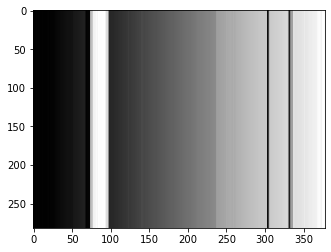

In [161]:
plt.figure()
plt.imshow(score_mat)


In [152]:
print(score_mat)

[[71, 78, 76, 72, 72, 76, 73, 76, 75, 79, 79, 76, 76, 76, 71, 61, 57, 51, 49, 46, 38, 44, 38, 40, 36, 38, 49, 49, 53, 50, 52, 60, 70, 80, 109, 142, 148, 171, 181, 219, 268, 314, 358, 415, 489, 556, 555, 520, 524, 551, 681, 825, 848, 874, 817, 785, 704, 610, 479, 411, 317, 334, 293, 259, 219, 204, 198, 194, 158, 117, 102, 111, 129, 246, 381, 417, 481, 504, 335, 197, 169, 148, 156, 152, 161, 166, 179, 180, 189, 203, 228, 264, 312, 347, 305, 552, 759, 913, 663, 398, 167, 96, 76, 66, 53, 49, 51, 49, 48, 50, 51, 55, 49, 52, 52, 50, 46, 51, 49, 52, 50, 52, 53, 53, 54, 53, 51, 47, 46, 46, 43, 48, 46, 136, 210, 222, 240, 249, 259, 252, 106, 65, 64, 72, 72, 70, 67, 66, 71, 59, 70, 62, 79, 198, 325, 472, 571, 634, 677, 679, 571, 460, 354, 288, 240, 230, 236, 240, 263, 266, 270, 263, 241, 218, 205, 176, 142, 109, 99, 147, 251, 353, 397, 445, 489, 497, 479, 437, 380, 335, 285, 235, 222, 223, 251, 295, 313, 316, 317, 313, 274, 179, 95, 68, 60, 69, 72, 75, 69, 66, 64, 56, 54, 50, 48, 51, 52, 51, 55,